In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [8]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

In [9]:
data = pd.read_csv("../1. Task and Data/train.csv", sep="|")

In [10]:
data['totalScanTimeInMinutes'] = data['totalScanTimeInSeconds'] / 60.0
data['scannedLineItems'] = data['scannedLineItemsPerSecond'] * data['totalScanTimeInSeconds']
data['pricePerScannedLineItem'] = data['grandTotal'] / data['scannedLineItems']
data['scansWithoutRegistrationPerScannedLineItem'] = data['scansWithoutRegistration'] / data['scannedLineItems']
data['quantityModificationsPerScannedLineItem'] = data['quantityModifications'] / data['scannedLineItems']
data['lineItemVoidsPerSecond'] = data['lineItemVoids'] / data['totalScanTimeInSeconds']
data['scansWithoutRegistrationPerSecond'] = data['scansWithoutRegistration'] / data['totalScanTimeInSeconds']
data['quantityModificationsPerSecond'] = data['quantityModifications'] / data['totalScanTimeInSeconds']
data['secondsPerEuro'] = data['totalScanTimeInSeconds'] / data['grandTotal']
data['lineItemVoidsPerEuro'] = data['lineItemVoids'] / data['grandTotal']
data['scansWithoutRegistrationPerEuro'] = data['scansWithoutRegistration'] / data['grandTotal']
data['quantityModificationsPerEuro'] = data['quantityModifications'] / data['grandTotal']

# Extra Trees Classifier

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
# load data

y = data['fraud']
x = data.drop('fraud',axis=1)

# feature extraction
model = ExtraTreesClassifier(criterion = 'entropy')
model.fit(x, y)

pd.DataFrame(model.feature_importances_, list(x), columns =['Importance']).sort_values(by='Importance', ascending = False)

,Importance
trustLevel,0.315695
scannedLineItems,0.205877
scannedLineItemsPerSecond,0.042468
totalScanTimeInMinutes,0.040812
scansWithoutRegistration,0.037000
totalScanTimeInSeconds,0.035617
lineItemVoidsPerPosition,0.035352
scansWithoutRegistrationPerScannedLineItem,0.029484
lineItemVoids,0.025692
pricePerScannedLineItem,0.024000


# SelectKBest

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

y = data['fraud']
x = data.drop('fraud',axis=1)

for feature_count in range(1, len(list(x)) + 1):
    best_features = SelectKBest(f_classif, k=feature_count).fit(x,y)
    print("Feature Count: " + str(feature_count) + ":")
    print(x.columns[best_features.get_support()].values)
    print()

Feature Count: 1:
['trustLevel']

Feature Count: 2:
['trustLevel' 'scannedLineItems']

Feature Count: 3:
['trustLevel' 'totalScanTimeInSeconds' 'scannedLineItems']

Feature Count: 4:
['trustLevel' 'totalScanTimeInSeconds' 'totalScanTimeInMinutes'
 'scannedLineItems']

Feature Count: 5:
['trustLevel' 'totalScanTimeInSeconds' 'totalScanTimeInMinutes'
 'scannedLineItems' 'pricePerScannedLineItem']

Feature Count: 6:
['trustLevel' 'totalScanTimeInSeconds' 'totalScanTimeInMinutes'
 'scannedLineItems' 'pricePerScannedLineItem'
 'quantityModificationsPerScannedLineItem']

Feature Count: 7:
['trustLevel' 'totalScanTimeInSeconds' 'totalScanTimeInMinutes'
 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem']

Feature Count: 8:
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoidsPerPosition'
 'totalScanTimeInMinutes' 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quanti

# Recursive Feature Elimination -> Model Specific

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

rfecv = RFECV(GradientBoostingClassifier(), min_features_to_select=1, cv=skf, scoring=my_custom_score)
rfecv = rfecv.fit(x,y)
print(str(rfecv.n_features_) + " features:")
print(np.array(list(x))[np.array(rfecv.support_)])

16 features:
['trustLevel' 'totalScanTimeInSeconds' 'grandTotal' 'lineItemVoids'
 'scansWithoutRegistration' 'scannedLineItemsPerSecond' 'valuePerSecond'
 'lineItemVoidsPerPosition' 'totalScanTimeInMinutes' 'scannedLineItems'
 'pricePerScannedLineItem' 'scansWithoutRegistrationPerScannedLineItem'
 'lineItemVoidsPerSecond' 'scansWithoutRegistrationPerSecond'
 'secondsPerEuro' 'scansWithoutRegistrationPerEuro']


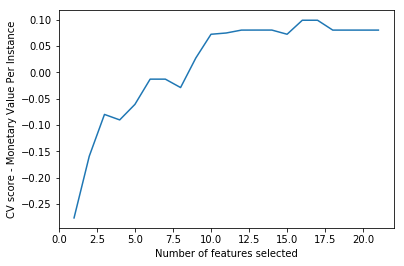

In [22]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("CV score - Monetary Value Per Instance")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [143]:
best_model = rfecv.estimator_

from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(y , best_model.predict(x.loc[:, rfecv.support_]))

monetary_value = get_monetary_value(cm)

True negative:  1775
False positive:  0
False negative:  0
True positive:  104
520 for 1879 instances in the test set
0.2767429483767962 per instance in the test set
